In [111]:
import matplotlib.pyplot as plt
import numpy as np
import util
import xarray as xr
from matplotlib import colors, ticker
from matplotlib.gridspec import GridSpec
from scipy import stats

chunks = {"x": 2000, "ncol": 2000}
t = -30

In [112]:
run = "dpscream_rce_large_3km_d_lpls304k_wbranch"
run_dir = f"/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/{run}/run/"
# file = run_dir + f"{run}_h0_last5days.nc"
file = run_dir + f"{run}.eam.h0.2000-02-20-10800.nc"
qsmall=1e-8

In [113]:
plt.rcParams.update({"font.size": 18})  # all to 18 if not specified other

In [114]:
print(file)
# ds = xr.open_dataset(file, chunks=chunks)[["crm_grid_x", "crm_grid_y", "CLDICE", "CLDLIQ", "T"]].isel(time=t)  
ds = xr.open_dataset(file, chunks=chunks).isel(time=t)
x = ds.crm_grid_x
y = ds.crm_grid_y
iwc = ds.CLDICE+ds.CLDLIQ
temp = ds['T']
time = ds.time
# del ds
print(x.shape, y.shape, time.values)

/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_d_lpls304k_wbranch/run/dpscream_rce_large_3km_d_lpls304k_wbranch.eam.h0.2000-02-20-10800.nc
(147456,) (147456,) 2000-02-21 09:00:00


In [115]:
# iwc.mean(dim=['ncol'], skipna=True).plot()

In [116]:
np.nansum(x)

23347202000.0

In [117]:
cross_mask = np.where(x < 100, 1, 0)
print(cross_mask.shape)
x0 = x.where(cross_mask)
y0 = y.where(cross_mask)
print(x0.shape, y0.shape)
ncross = np.nansum(cross_mask)
print(ncross)

(147456,)
(147456,) (147456,)
1536


In [118]:
w = util.omega2w(ds.OMEGA, ds.lev*100, temp)


In [119]:
lw_heating = ds.QRL
sw_heating = ds.QRS
del ds

In [120]:
nuc = (
    xr.open_dataset(run_dir + run + "_NUC_hrs.nc").sel(time=time, method="nearest").NUC
)
bcu = (
    xr.open_dataset(run_dir + run + "_BCU_hrs.nc").sel(time=time, method="nearest").BCU
)
z = (
    xr.open_dataset(run_dir + run + "_Z3_mean.nc")
    # xr.open_dataset(run_dir + run + "_Zmean_last5days.nc")
    # .sel(time=time, method="nearest")
    .Z3[0, :, 0, 0]/1000
)
print(time.values, nuc.time.values)
# nuc

2000-02-21 09:00:00 2000-02-21 09:00:00


In [121]:
nuc.shape, bcu.shape, z.shape

((128, 147456), (128, 147456), (128,))

In [122]:
# nuc.plot.hist(bins=np.arange(0, 50))
# plt.show()
# bcu.plot.hist(bins=np.arange(0, 50))
# plt.show()

In [123]:
# plt.scatter(y0/1000, x0)
# plt.show()

In [124]:
# y_plot = np.linspace(0,y[-1].values,ncross)
# print(y_plot.shape)

In [125]:
iwc_plot = iwc.where(cross_mask[np.newaxis, :])
nuc_plot = nuc.where((iwc>qsmall)&(cross_mask[np.newaxis, :]))
bcu_plot = bcu.where((iwc>qsmall)&(cross_mask[np.newaxis, :]))
qrl_plot = lw_heating.where((iwc>qsmall)&(cross_mask[np.newaxis, :]))
qrs_plot = sw_heating.where((iwc>qsmall)&(cross_mask[np.newaxis, :]))
w_plot = w.where((iwc>qsmall)&(cross_mask[np.newaxis, :]))

In [126]:
y.shape, z.shape, iwc_plot.shape, nuc_plot.shape, bcu_plot.shape#, cld_plot.shape

((147456,), (128,), (128, 147456), (128, 147456), (128, 147456))

In [127]:
# iwc_plot.mean(dim=['ncol'], skipna=True).plot()
y.values

array([0.0000000e+00, 2.7639321e+03, 7.2360679e+03, ..., 5.1172360e+06,
       5.1127640e+06, 5.1172360e+06], dtype=float32)

2000-02-21T09h


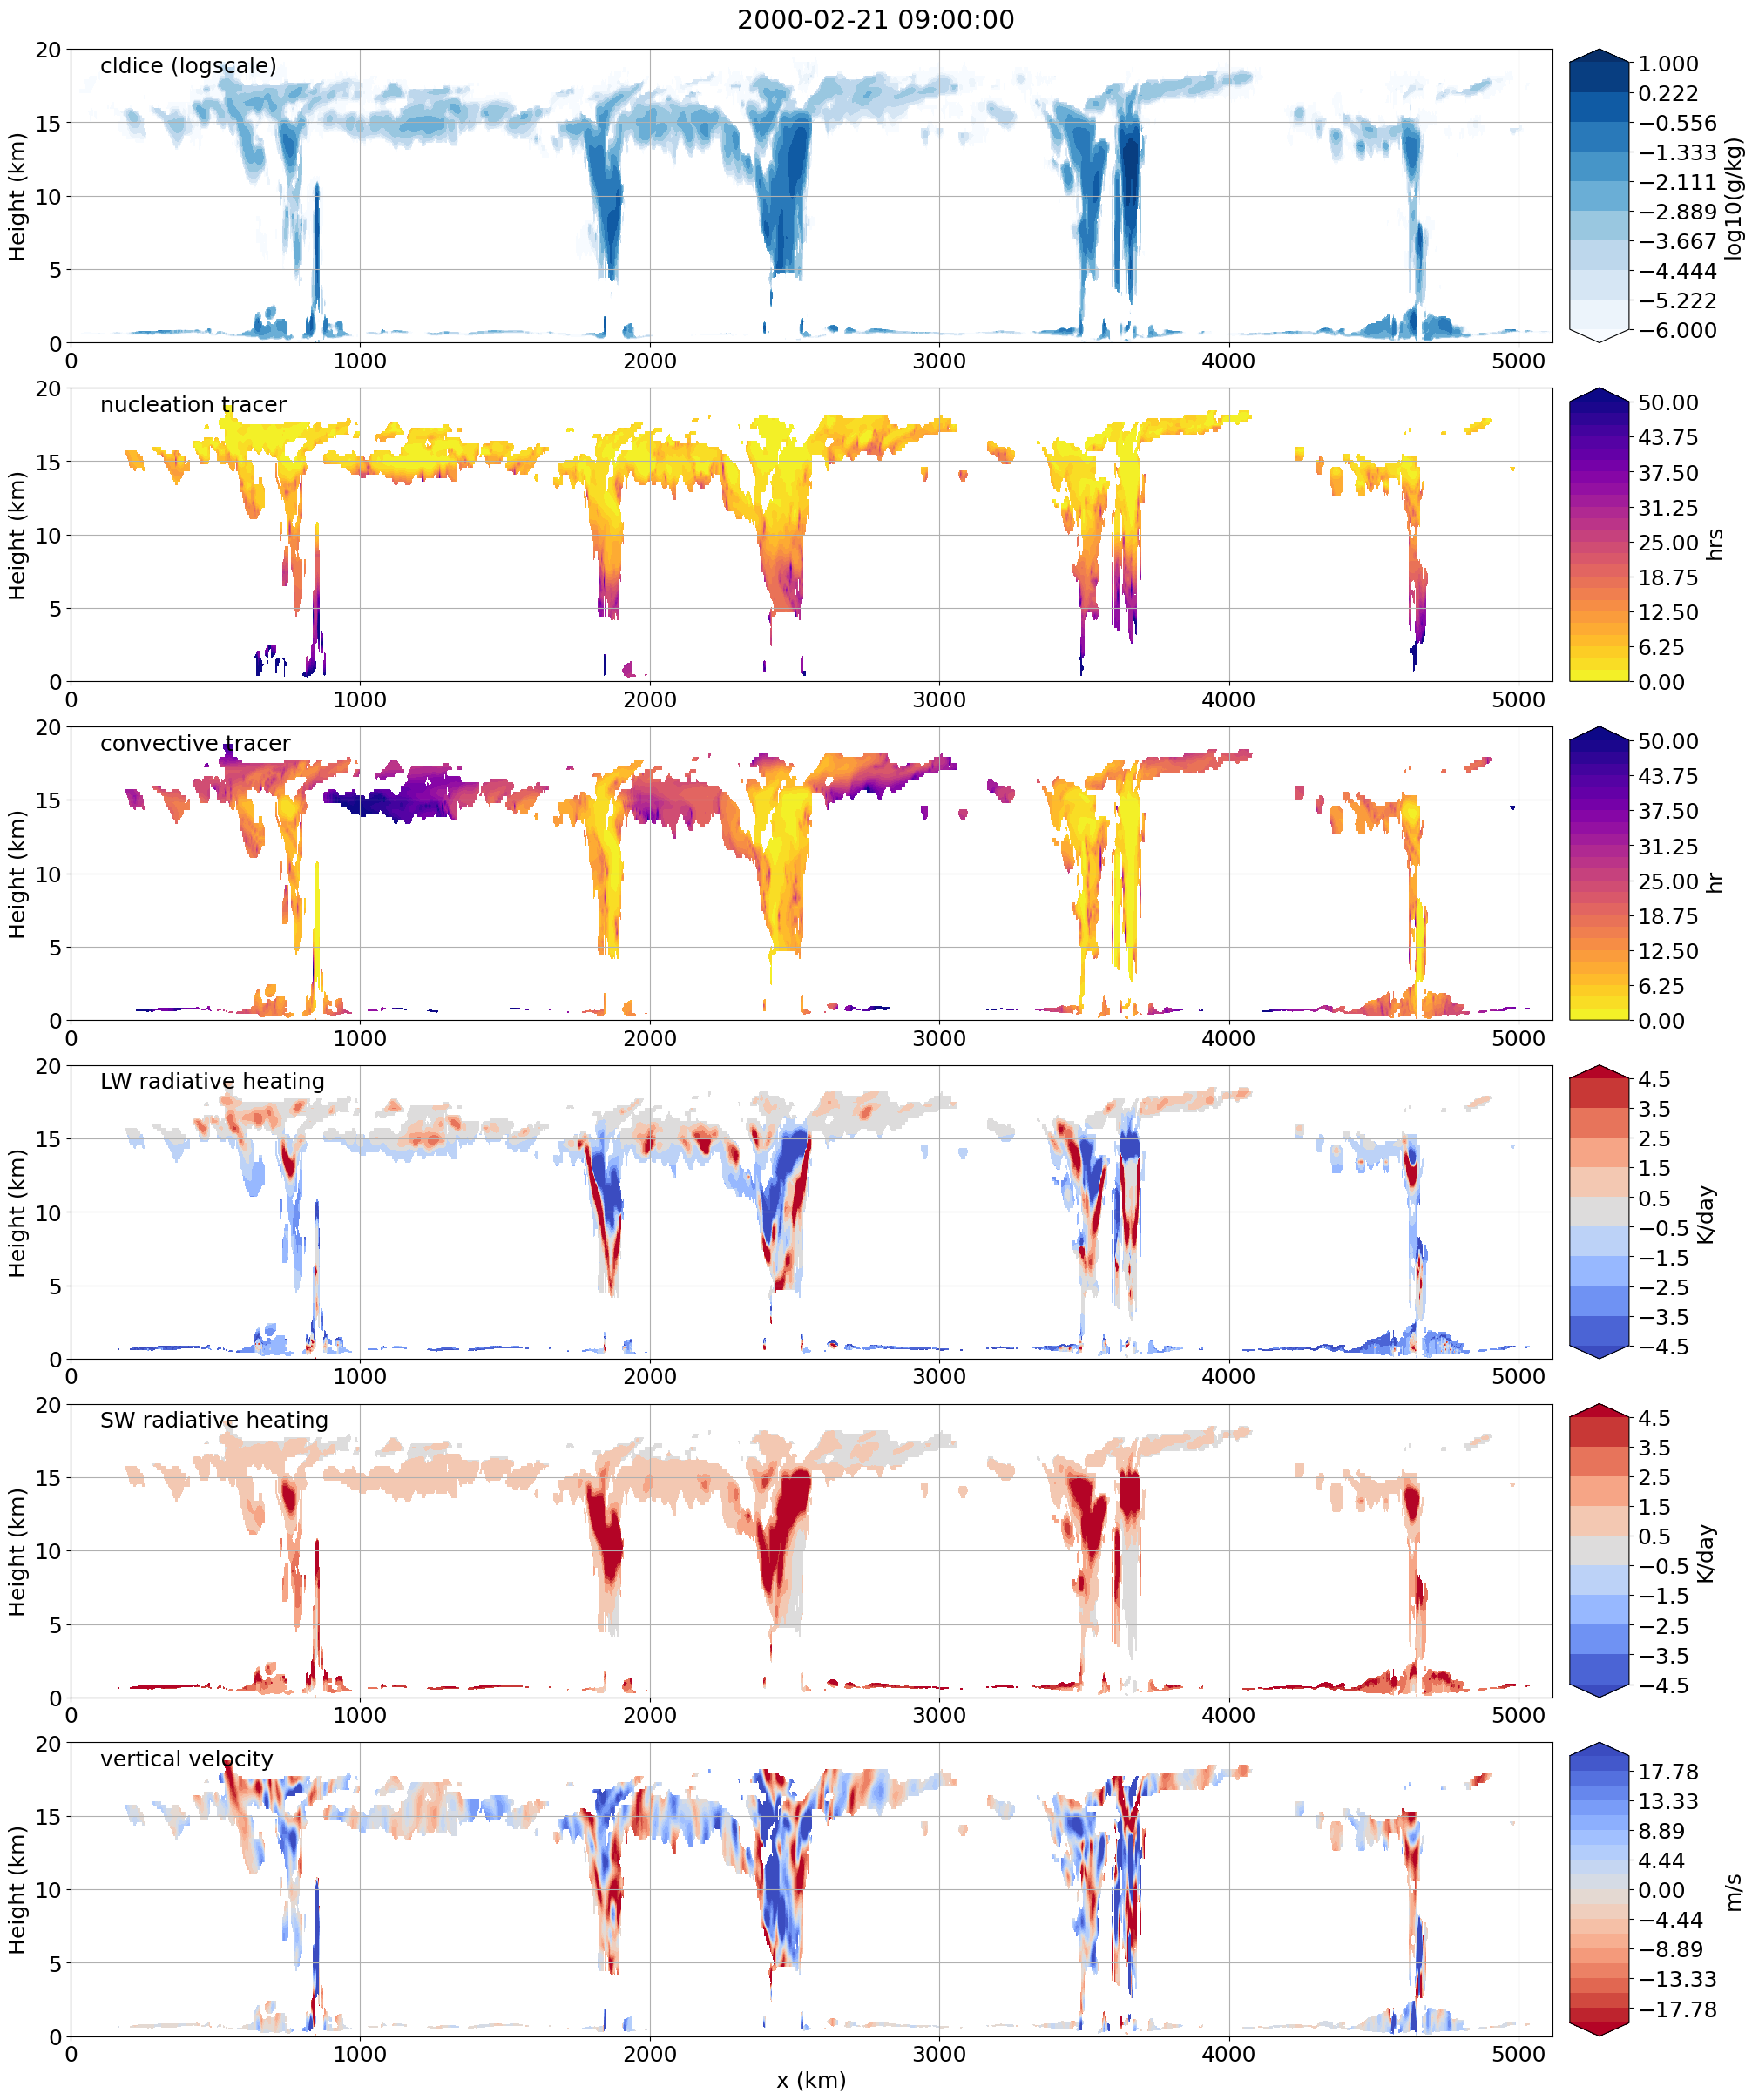

In [128]:
fig = plt.figure(figsize=(20, 24), layout="constrained")
gs = GridSpec(6, 2, figure=fig, width_ratios=[100, 4], hspace=0)
ax0 = fig.add_subplot(gs[0, 0])
cax0 = fig.add_subplot(gs[0, 1])
cf = ax0.contourf(
    y / 1000,
    z,
    np.log10(iwc_plot * 1000),
    levels=np.linspace(-6, 1, 10),
    # vmin=-6, vmax=1,
    extend="both",
    cmap="Blues",
)
plt.colorbar(cf, cax=cax0, label="log10(g/kg)")
ax1 = fig.add_subplot(gs[1, 0])
cax1 = fig.add_subplot(gs[1, 1])
cf = ax1.contourf(
    y / 1000,
    z,
    nuc_plot,
    levels=np.linspace(0, 50, 25),
    # vmin=0, vmax=50,
    extend="max",
    cmap="plasma_r",
)
plt.colorbar(cf, cax=cax1, label="hrs")
ax2 = fig.add_subplot(gs[2, 0])
cax2 = fig.add_subplot(gs[2, 1])
cf = ax2.contourf(
    y / 1000,
    z,
    bcu_plot,
    levels=np.linspace(0, 50, 25),
    # vmin=0, vmax=50,
    extend="max",
    cmap="plasma_r",
)
plt.colorbar(cf, cax=cax2, label="hr")
ax3 = fig.add_subplot(gs[3, 0])
cax3 = fig.add_subplot(gs[3, 1])
cf = ax3.contourf(
    y / 1000,
    z,
    qrl_plot * 3600 * 24,
    levels=np.linspace(-4.5,4.5,10),
    # vmin=-4.5, vmax=4.5,
    extend="both",
    cmap="coolwarm",
)
plt.colorbar(cf, cax=cax3, label="K/day")
ax4 = fig.add_subplot(gs[4, 0])
cax4 = fig.add_subplot(gs[4, 1])
cf = ax4.contourf(
    y / 1000,
    z,
    qrs_plot * 3600 * 24,
    levels=np.linspace(-4.5, 4.5, 10),
    # vmin=-4.5, vmax=4.5,
    extend="both",
    cmap="coolwarm",
)
plt.colorbar(cf, cax=cax4, label="K/day")
ax5 = fig.add_subplot(gs[5, 0])
cax5 = fig.add_subplot(gs[5, 1])
cf = ax5.contourf(
    y / 1000,
    z,
    w_plot*100,
    levels=np.linspace(-20, 20, 19),
    # vmin=-1, vmax=1,
    extend="both",
    cmap="coolwarm_r",
)
plt.colorbar(cf, cax=cax5, label="m/s")
ax0.set(ylim=[0, 20], #xlim=[100,1900],
        ylabel="Height (km)")
ax1.set(ylim=[0, 20], #xlim=[100,1900],
        ylabel="Height (km)")
ax2.set(ylim=[0, 20], #xlim=[100,1900],
        ylabel="Height (km)")
ax3.set(ylim=[0, 20], #xlim=[100,1900],
        ylabel="Height (km)")
ax4.set(ylim=[0, 20], #xlim=[100,1900],
        ylabel="Height (km)")
ax5.set(ylim=[0, 20], #xlim=[100,1900],
        ylabel="Height (km)", xlabel="x (km)")
ax0.grid(True)
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
ax4.grid(True)
ax5.grid(True)
ax0.annotate("cldice (logscale)", xy=(0.02,0.92), xycoords="axes fraction")
ax1.annotate("nucleation tracer", xy=(0.02,0.92), xycoords="axes fraction")
ax2.annotate("convective tracer", xy=(0.02,0.92), xycoords="axes fraction")
ax3.annotate("LW radiative heating", xy=(0.02,0.92), xycoords="axes fraction")
ax4.annotate("SW radiative heating", xy=(0.02,0.92), xycoords="axes fraction")
ax5.annotate("vertical velocity", xy=(0.02,0.92), xycoords="axes fraction")
fig.suptitle(str(nuc.time.values))
time_string = str(time.values).replace(" ","T").split(":")[0]+"h"
print(time_string)
plt.savefig("../plots/large/cross_section_iwc_nuc_bcu_qrl_qrs_w_"+
            f"{run}_{time_string}.png")
plt.show()